# Apply Signature Analysis to Cell Morphology Features

Gregory Way, 2020

Here, I apply [`singscore`](https://bioconductor.org/packages/devel/bioc/vignettes/singscore/inst/doc/singscore.html) ([Foroutan et al. 2018](https://doi.org/10.1186/s12859-018-2435-4)) to our Cell Painting profiles.
This notebook largely follows the [package vignette](https://bioconductor.org/packages/devel/bioc/vignettes/singscore/inst/doc/singscore.html).

I generate two distinct signatures.

1. Comparing Clone A and E resistant clones to sensitive wildtype cell lines.
   * Clones A and E both have a confirmed _PSMB5_ mutation which is known to cause bortezomib resistance.
2. Derived from comparing four other resistant clones to four other sensitive wildtype clones.
   * We do not know the resistance mechanism in these four resistant clones.

However, we can hypothesize that the mechanisms are similar based on single sample enrichment using the potential PSMB5 signature.

To review how I derived these signatures see `1.derive-bulk-signatures.ipynb`.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggbeeswarm))

suppressPackageStartupMessages(library(singscore))

source(file.path("utils", "singscore_utils.R"))

In [2]:
seed <- 1234
num_permutations <- 1000
datasets <- c("four_clone", "cloneAE")
data_dir <- "data"
output_dir <- file.path("results", "singscore")
figure_dir <- file.path("figures", "singscore")

In [3]:
set.seed(seed)

## Load Datasets

In [4]:
data_cols <- readr::cols(
  .default = readr::col_double(),
  Metadata_Plate = readr::col_character(),
  Metadata_Well = readr::col_character(),
  Metadata_batch = readr::col_character(),
  Metadata_clone_number = readr::col_character(),
  Metadata_plate_ID = readr::col_integer(),
  Metadata_plate_map_name = readr::col_character(),
  Metadata_treatment = readr::col_character(),
  Metadata_clone_type = readr::col_character()
)

dataset_dfs <- list()
for (dataset in datasets) {
    data_file <- file.path(data_dir, paste0("bulk_profiles_", dataset, ".csv.gz"))
    data_df <- readr::read_csv(data_file, col_types=data_cols)
    
    # Generate unique sample names (for downstream merging of results)
    sample_names <- paste(
        data_df$Metadata_clone_number,
        data_df$Metadata_Plate,
        data_df$Metadata_Well,
        data_df$Metadata_batch,
        sep = "_"
    )

    data_df <- data_df %>%
        dplyr::mutate(Metadata_unique_sample_name = sample_names)

    dataset_dfs[[dataset]] <- data_df
}

## Load signatures

In [5]:
sig_cols <- readr::cols(
  feature = readr::col_character(),
  estimate_tukey = readr::col_double(),
  adj.p.value_tukey = readr::col_double()
)

signature_dfs <- list()
signature_features <- list()
for (dataset in datasets) {
    # Load signature
    sig_file <- file.path("results", "signatures", paste0("bulk_signature_", dataset, ".tsv"))
    signature_df <- readr::read_tsv(sig_file, col_types=sig_cols)
    
    # Extract features that are up and down in the signature
    up_features <- signature_df %>% dplyr::filter(estimate_tukey > 0) %>% dplyr::pull(feature)
    down_features <- signature_df %>% dplyr::filter(estimate_tukey < 0) %>% dplyr::pull(feature)
    
    signature_features[[dataset]] <- list("up" = up_features, "down" = down_features)
    signature_dfs[[dataset]] <- signature_df
}

## Apply singscore

Apply the algorithm to each dataset using each signature

In [6]:
sing_score_results <- list()
for (dataset in datasets) {
    data_df = dataset_dfs[[dataset]]
    sing_score_results[[dataset]] <- list()
    for (signature in datasets) {
        signature_info <- signature_features[[signature]]

        # Rank the features per sample
        rank_df <- getRankData(df = data_df)
        
        # Get the scores
        simple_score_df <- applySimpleScore(
            df = data_df,
            rank_df = rank_df,
            sig_feature_list = signature_info
        )
    
        # Permute the data to generate null scores
        permuted_output <- getPermutedRanks(
            df = data_df,
            rank_df = rank_df,
            simple_score_df = simple_score_df,
            sig_feature_list = signature_info,
            num_permutations = num_permutations
        )
        
        full_results_df <- permuted_output[["results"]]
        permuted <- permuted_output[["permuted"]]

        # Annotate some key metadata and store to list
        full_results_df <- full_results_df %>%
            dplyr::mutate(dataset = dataset, signature = signature)
        
        # Output file
        output_file = file.path(
            output_dir, paste0("data_", dataset, "_signature_", signature, ".tsv.gz")
        )
        full_results_df %>% readr::write_tsv(output_file)
        
        # Store results in a list for downstream plotting
        sing_score_results[[dataset]][[signature]] <- list(
            "results" = full_results_df, "permuted" = permuted
        )
    }
}

Warning message:
“'tidy.numeric' is deprecated.
See help("Deprecated")”Warning message:
“`data_frame()` is deprecated as of tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”Warning message:
“'tidy.numeric' is deprecated.
See help("Deprecated")”Warning message:
“'tidy.numeric' is deprecated.
See help("Deprecated")”Warning message:
“'tidy.numeric' is deprecated.
See help("Deprecated")”

## Visualize Results

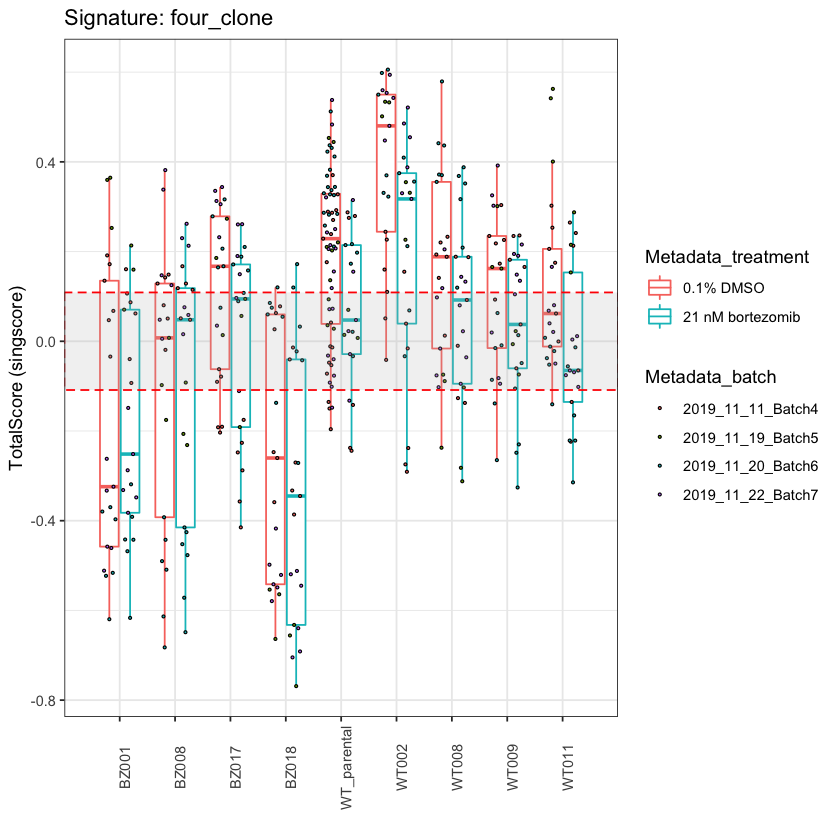

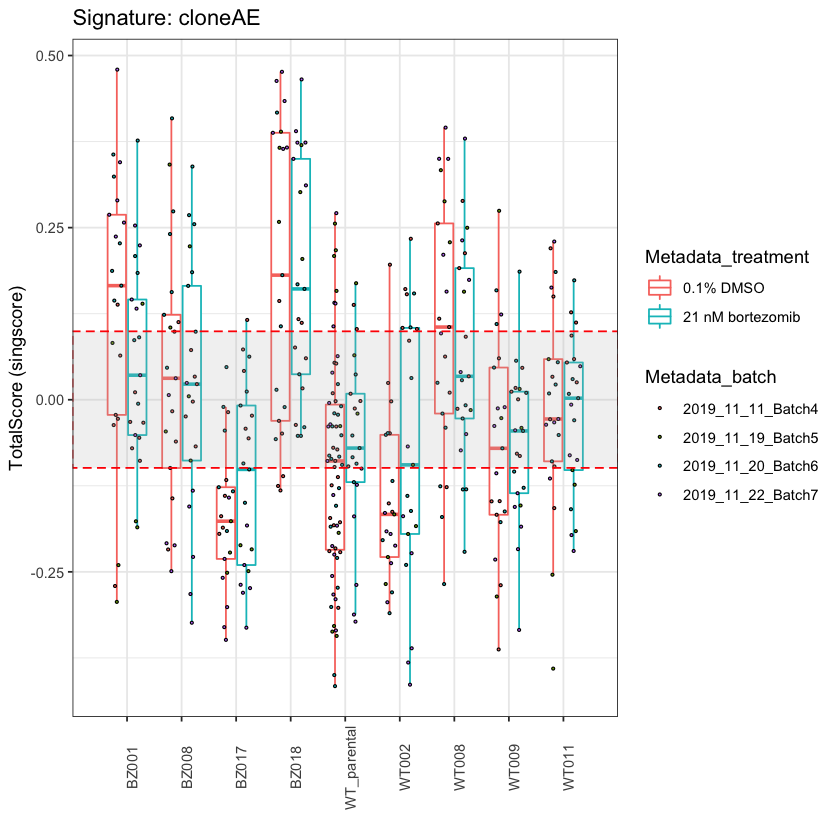

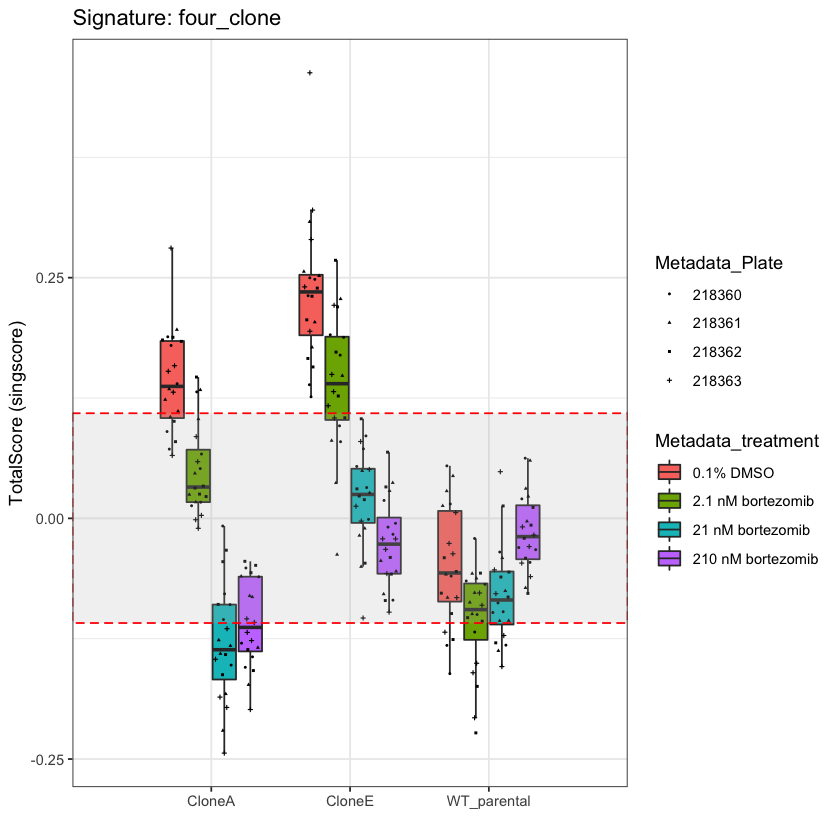

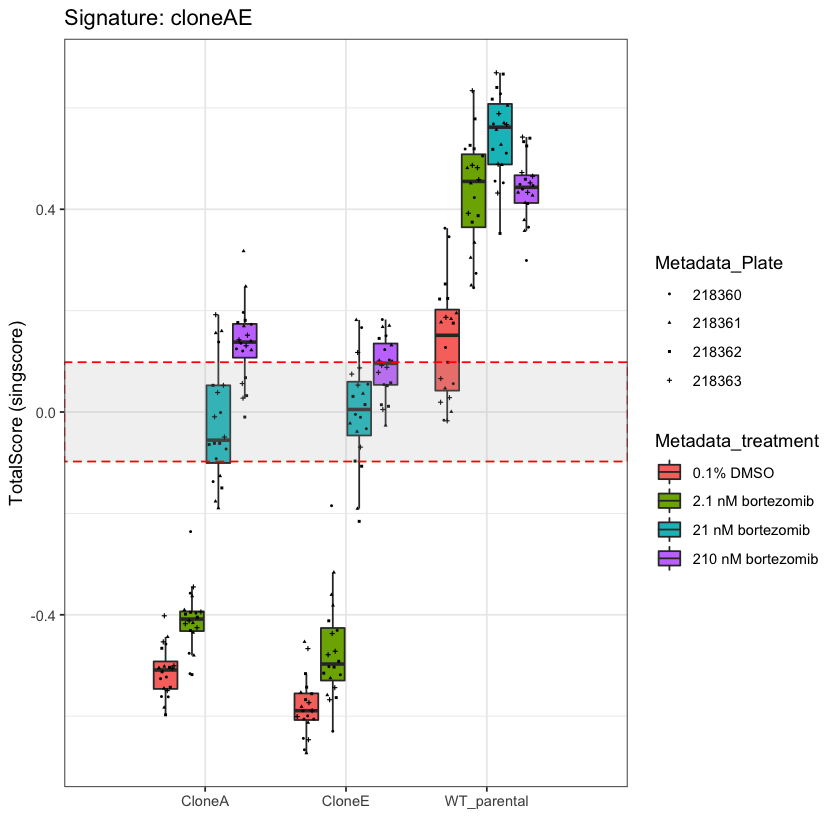

In [7]:
for (dataset in datasets) {
    for (signature in datasets) {
        output_file <- file.path(
            figure_dir, paste0("data_", dataset, "_signature_", signature, "_apply_singscore.png")
            )
        result <- sing_score_results[[dataset]][[signature]][["results"]]
        permute_result <- sing_score_results[[dataset]][[signature]][["permuted"]]

        min_val <- quantile(as.vector(as.matrix(permute_result)), 0.05)
        max_val <- quantile(as.vector(as.matrix(permute_result)), 0.95)
        
        results_gg <- ggplot(result,
           aes(y = TotalScore,
               x = Metadata_clone_number,
               group = paste(Metadata_clone_number, Metadata_treatment)))
        
        if (dataset == "cloneAE") {
            results_gg <- results_gg +
                geom_boxplot(aes(fill = Metadata_treatment), outlier.alpha = 0) +
                geom_quasirandom(
                    aes(shape = Metadata_Plate),
                    dodge.width = 0.75,
                    size = 0.5) +
            theme_bw()
        } else {
            results_gg <- results_gg +
                geom_boxplot(aes(color = Metadata_treatment), outlier.alpha = 0) +
                geom_quasirandom(
                    aes(fill = Metadata_batch),
                    dodge.width = 0.75,
                    size = 0.5,
                    shape = 21) +
                theme_bw() +
                theme(axis.text.x = element_text(angle = 90))
        }
        
        results_gg <- results_gg +
            annotate("rect",
                     ymin = min_val,
                     ymax = max_val,
                     xmin = 0,
                     xmax = length(unique(result$Metadata_clone_number)) + 1,
                     alpha = 0.2,
                     color = "red",
                     linetype = "dashed",
                     fill = "grey") +
            xlab("") +
            ylab("TotalScore (singscore)") +
            ggtitle(paste("Signature:", signature))
        
        print(results_gg)
        ggsave(output_file, height = 4, width = 6, dpi = 400)
    }
}